# Monte Carlo Simulations: Finite-Sample Conditioning in DML

This notebook accompanies the short communication:

> **"Finite-Sample Conditioning in Double Machine Learning: A Short Note"**

---

## 1. Introduction

### Theoretical Background

We consider the **Partially Linear Regression (PLR)** model (Robinson 1988):
$$
Y = D \cdot \theta_0 + g_0(X) + \varepsilon, \quad \mathbb{E}[\varepsilon \mid D, X] = 0
$$

where $Y \in \mathbb{R}$ is the outcome, $D \in \mathbb{R}$ is the scalar treatment, and $X \in \mathbb{R}^p$ are covariates.

The **DML estimator** (Chernozhukov et al. 2018) uses the orthogonal score:
$$
\psi(W; \theta, \eta) = (D - m(X)) \cdot \big(Y - g(X) - \theta \cdot (D - m(X))\big)
$$

with nuisance functions $m_0(X) = \mathbb{E}[D|X]$ and cross-fitted ML estimates $\hat{m}, \hat{g}$.

### The Condition Number

Let $\hat{U}_i = D_i - \hat{m}(X_i)$ be the residualized treatments. The **empirical Jacobian** is:
$$
\hat{J}_\theta = -\frac{1}{n} \sum_i \hat{U}_i^2
$$

The **DML condition number** is:
$$
\kappa_{\mathrm{DML}} = \frac{1}{|\hat{J}_\theta|} = \frac{n}{\sum_i \hat{U}_i^2}
$$

### Key Theoretical Result

The paper's main expansion shows:
$$
\hat{\theta} - \theta_0 = \kappa_{\mathrm{DML}} \cdot (S_n + B_n) + R_n
$$

where:
- $S_n = \frac{1}{n} \sum_i \psi(W_i; \theta_0, \eta_0) = O_P(n^{-1/2})$ is the score term
- $B_n$ is the nuisance bias term
- $R_n$ is a remainder

**Implication:** Large $\kappa_{\mathrm{DML}}$ amplifies both variance and bias, leading to poor coverage and slow CI shrinkage even at large $n$.

### Simulation Goal

We vary $\kappa_{\mathrm{DML}}$ through **overlap** (residual variation in $D$ given $X$) and covariate **correlation** to demonstrate:
1. Coverage failure when $\kappa_{\mathrm{DML}}$ is large
2. CI length shrinking slowly in ill-conditioned regimes

In [41]:
# Standard library
import os
import sys
import warnings

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore')

# Add code directory to path
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

# Import simulation module
from simulations import (
    generate_plr_data,
    dml_plr_estimator,
    run_simulation_grid,
    compute_summary_statistics,
    format_summary_for_latex,
    DGP_CONFIGS,
    OVERLAP_CONFIG,
    get_beta_D,
    get_gamma,
    get_sigma_U_sq,
    compute_theoretical_r2,
)

# Output directory
RESULTS_DIR = '../results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Plot settings
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.dpi': 100,
})

print("Setup complete.")
print(f"Results will be saved to: {os.path.abspath(RESULTS_DIR)}")

Setup complete.
Results will be saved to: /Users/gabrielsaco/Documents/GitHub/dml_paper/results


---
## 2. Data-Generating Process (DGP)

### Model Specification

We use the canonical PLR model:
$$
Y = D \cdot \theta_0 + g_0(X) + \varepsilon, \quad \varepsilon \sim N(0, 1)
$$
$$
D = X'\beta_D + U, \quad U \sim N(0, \sigma_U^2)
$$
$$
X \sim N(0, \Sigma(\rho)), \quad \Sigma_{jk} = \rho^{|j-k|}
$$

This **Toeplitz/AR(1) covariance structure** for $X$ is standard in PLR/DML simulations (Chernozhukov et al. 2018; Bach et al. 2022, DoubleML).

### Coefficient Choices

**Treatment equation coefficients:** $\beta_D = (1, 0.8, 0.6, 0.4, 0.2, 0, \ldots, 0) \in \mathbb{R}^{10}$

We use a decaying pattern on the first 5 covariates to avoid dominance by a single variable, following simulation practice in Chernozhukov et al. (2018) and Bach et al. (2022).

**Nuisance function:** $g_0(X) = \gamma' \sin(X)$ with $\gamma = (1, 0.5, 0.25, 0.125, 0.0625, 0, \ldots, 0)$

This smooth nonlinear function is complex enough to require ML estimation but remains computationally tractable, similar to semiparametric benchmark designs in Robinson (1988) and Chernozhukov et al. (2018).

### Overlap Calibration via $R^2(D|X)$

Instead of arbitrary $\sigma_U^2$ values, we **calibrate overlap levels** by targeting specific $R^2(D|X)$ values:

$$
R^2(D|X) = \frac{\text{Var}(X'\beta_D)}{\text{Var}(D)} = \frac{\beta_D' \Sigma \beta_D}{\beta_D' \Sigma \beta_D + \sigma_U^2}
$$

This calibration approach follows Zimmert (2018) and Naghi (2021), who systematically vary \(R^2_{D\mid X}\) to study causal ML performance.

| Overlap Level | Target \(R^2(D \mid X)\) | Interpretation |
|---------------|---------------------------|----------------|
| High          | 0.75                      | Good overlap: substantial residual variation in \(D\). |
| Moderate      | 0.90                      | Moderate overlap: limited residual variation in \(D\).  |
| Low           | 0.97                      | Poor overlap: \(D\) is nearly deterministic given \(X\). |


### Coefficient Vectors

In [42]:
# Display coefficient choices
p = 10
beta_D = get_beta_D(p)
gamma = get_gamma(p)

print("Coefficient Vectors (p = 10)")
print("=" * 50)
print(f"β_D = {beta_D}")
print(f"γ   = {gamma}")
print("\nNote: Decaying patterns avoid single-covariate dominance.")

Coefficient Vectors (p = 10)
β_D = [1.  0.8 0.6 0.4 0.2 0.  0.  0.  0.  0. ]
γ   = [1.     0.5    0.25   0.125  0.0625 0.     0.     0.     0.     0.    ]

Note: Decaying patterns avoid single-covariate dominance.


### Overlap Calibration Table

In [43]:
# Display overlap calibration
print("Overlap Calibration: σ_U² for Target R²(D|X)")
print("=" * 60)
print(f"{'Overlap':<12} {'Target R²':<12} {'ρ=0.0':<12} {'ρ=0.5':<12} {'ρ=0.9':<12}")
print("-" * 60)

for overlap, config in OVERLAP_CONFIG.items():
    target_r2 = config['target_r2']
    sigmas = [get_sigma_U_sq(overlap, rho, p) for rho in [0.0, 0.5, 0.9]]
    print(f"{overlap:<12} {target_r2:<12.2f} {sigmas[0]:<12.3f} {sigmas[1]:<12.3f} {sigmas[2]:<12.3f}")

print("\nNote: σ_U² is calibrated so that R²(D|X) = target, accounting for ρ.")

Overlap Calibration: σ_U² for Target R²(D|X)
Overlap      Target R²    ρ=0.0        ρ=0.5        ρ=0.9       
------------------------------------------------------------
high         0.75         0.733        1.495        2.615       
moderate     0.90         0.244        0.498        0.872       
low          0.97         0.068        0.139        0.243       

Note: σ_U² is calibrated so that R²(D|X) = target, accounting for ρ.


### DGP Design Table

We use 9 DGPs spanning three conditioning regimes:
- **Group A (Well-conditioned):** High overlap → small $\kappa_{\mathrm{DML}}$
- **Group B (Moderately ill-conditioned):** Moderate overlap
- **Group C (Severely ill-conditioned):** Low overlap → large $\kappa_{\mathrm{DML}}$

In [44]:
# Build DGP table with calibrated values
dgp_data = []
for config in DGP_CONFIGS:
    dgp_id = config['dgp_id']
    n = config['n']
    rho = config['rho']
    overlap = config['overlap']
    desc = config.get('description', '')
    
    sigma_U_sq = get_sigma_U_sq(overlap, rho, p)
    theor_r2 = compute_theoretical_r2(rho, p, sigma_U_sq)
    
    dgp_data.append({
        'DGP': dgp_id,
        'n': n,
        'ρ': rho,
        'Overlap': overlap,
        'σ_U²': round(sigma_U_sq, 3),
        'R²(D|X)': round(theor_r2, 3),
        'Description': desc,
    })

dgp_table = pd.DataFrame(dgp_data)
print("DGP Configuration Table")
print("=" * 100)
print(dgp_table.to_string(index=False))

DGP Configuration Table
DGP    n   ρ  Overlap  σ_U²  R²(D|X)                                         Description
 A1  500 0.0     high 0.733     0.75               Baseline: independent X, high overlap
 A2  500 0.5     high 1.495     0.75                  Moderate correlation, high overlap
 A3 2000 0.5     high 1.495     0.75         Large n, moderate correlation, high overlap
 B1  500 0.0 moderate 0.244     0.90                     Independent X, moderate overlap
 B2  500 0.5 moderate 0.498     0.90                    Moderate correlation and overlap
 B3 2000 0.5 moderate 0.498     0.90           Large n, moderate correlation and overlap
 C1  500 0.5      low 0.139     0.97                   Moderate correlation, low overlap
 C2 2000 0.5      low 0.139     0.97          Large n, moderate correlation, low overlap
 C3 2000 0.9      low 0.243     0.97 Large n, high correlation, low overlap (worst case)


### Verify DGP Implementation

In [45]:
# Sanity check: verify R² calibration
print("Verification: Sample R²(D|X) vs Target")
print("=" * 50)

for overlap in ['high', 'moderate', 'low']:
    Y, D, X, info = generate_plr_data(n=10000, rho=0.5, overlap=overlap, seed=42)
    target_r2 = OVERLAP_CONFIG[overlap]['target_r2']
    sample_r2 = info['sample_r2']
    print(f"{overlap:<10} overlap: target R² = {target_r2:.3f}, sample R² = {sample_r2:.3f}")

print("\n✓ R² calibration verified.")

Verification: Sample R²(D|X) vs Target
high       overlap: target R² = 0.750, sample R² = 0.763
moderate   overlap: target R² = 0.900, sample R² = 0.910
low        overlap: target R² = 0.970, sample R² = 0.976

✓ R² calibration verified.


---
## 3. DML Estimator and $\kappa_{\mathrm{DML}}$

### Cross-Fitted DML

We implement DML with $K=5$ fold cross-fitting:

1. Split data into $K$ folds
2. For each fold $k$, fit on $I_k^c$:
   - $\hat{m}(X) \approx \mathbb{E}[D|X]$
   - $\hat{\ell}(X) \approx \mathbb{E}[Y|X]$
3. Compute out-of-fold residuals:
   - $\hat{U}_i = D_i - \hat{m}(X_i)$
   - $\hat{V}_i = Y_i - \hat{\ell}(X_i)$
4. DML estimate: $\hat{\theta} = \frac{\sum_i \hat{U}_i \hat{V}_i}{\sum_i \hat{U}_i^2}$

### ML Learner

We use **Random Forest** with conservative hyperparameters (200 trees, max_depth=5). This avoids overfitting while providing sufficient flexibility for nonlinear nuisances.

In [46]:
# Demo: DML estimator across overlap levels
print("DML Estimator Demo (n=2000, ρ=0.5)")
print("=" * 70)
print(f"{'Overlap':<12} {'θ̂':<10} {'SE':<10} {'κ_DML':<10} {'95% CI':<25}")
print("-" * 70)

for overlap in ['high', 'moderate', 'low']:
    Y, D, X, _ = generate_plr_data(n=2000, rho=0.5, overlap=overlap, seed=42)
    result = dml_plr_estimator(Y, D, X, K=5, learner='rf', random_state=42)
    
    ci_str = f"[{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]"
    print(f"{overlap:<12} {result['theta_hat']:<10.4f} {result['se']:<10.4f} "
          f"{result['kappa_dml']:<10.3f} {ci_str:<25}")

print("\nNote: As overlap decreases, κ_DML increases (worse conditioning).")

DML Estimator Demo (n=2000, ρ=0.5)
Overlap      θ̂         SE         κ_DML      95% CI                   
----------------------------------------------------------------------
high         1.0019     0.0174     0.554      [0.9678, 1.0360]         
moderate     0.9768     0.0264     1.232      [0.9250, 1.0286]         
low          0.9278     0.0354     2.188      [0.8585, 0.9971]         

Note: As overlap decreases, κ_DML increases (worse conditioning).


---
## 4. Monte Carlo Simulation

### Configuration

In [47]:
# ============================================================================
# SIMULATION CONFIGURATION
# ============================================================================

# Number of Monte Carlo replications per DGP
# For quick testing: N_REPS = 50
# For paper results: N_REPS = 500
N_REPS = 500

# Cross-fitting folds
K_FOLDS = 5

# ML learner
LEARNER = 'rf'  # Random Forest

# True treatment effect
THETA0 = 1.0

# Base seed for reproducibility
BASE_SEED = 2024

# DGPs to run
DGPS_TO_RUN = DGP_CONFIGS

print("Simulation Configuration")
print("=" * 40)
print(f"Replications per DGP:  {N_REPS}")
print(f"Cross-fitting folds:   {K_FOLDS}")
print(f"ML learner:            {LEARNER}")
print(f"True θ₀:               {THETA0}")
print(f"Number of DGPs:        {len(DGPS_TO_RUN)}")
print(f"Total estimations:     {len(DGPS_TO_RUN) * N_REPS:,}")

Simulation Configuration
Replications per DGP:  500
Cross-fitting folds:   5
ML learner:            rf
True θ₀:               1.0
Number of DGPs:        9
Total estimations:     4,500


### Run Simulations

In [ ]:
# ============================================================================
# RUN MONTE CARLO SIMULATIONS
# ============================================================================
# 
# By default, this cell loads pre-computed results from the CSV file.
# Set RUN_NEW = True to re-run the Monte Carlo simulations from scratch.
# WARNING: Re-running takes approximately 10-20 minutes with N_REPS=500.
# ============================================================================

RESULTS_CSV = f'{RESULTS_DIR}/simulation_results_full.csv'
RUN_NEW = False  # Set True to re-run simulations; False to load existing results

if RUN_NEW or not os.path.exists(RESULTS_CSV):
    print("Running Monte Carlo simulations...")
    print("This may take 10-20 minutes for N_REPS=500.\n")
    
    results_df = run_simulation_grid(
        dgp_configs=DGPS_TO_RUN,
        n_reps=N_REPS,
        p=10,
        theta0=THETA0,
        K=K_FOLDS,
        learner=LEARNER,
        base_seed=BASE_SEED,
        verbose=True,
    )
    
    results_df.to_csv(RESULTS_CSV, index=False)
    print(f"\nResults saved to: {RESULTS_CSV}")
else:
    print(f"Loading existing results from: {RESULTS_CSV}")
    results_df = pd.read_csv(RESULTS_CSV)

print(f"\nTotal replications: {len(results_df):,}")

Running Monte Carlo simulations...
This may take 10-20 minutes for N_REPS=500.

[1/9] DGP A1: n=500, ρ=0.0, high overlap
    Baseline: independent X, high overlap
    Completed 100/500 replications
    Completed 200/500 replications
    Completed 300/500 replications
    Completed 400/500 replications
    Completed 500/500 replications
[2/9] DGP A2: n=500, ρ=0.5, high overlap
    Moderate correlation, high overlap
    Completed 100/500 replications
    Completed 200/500 replications
    Completed 300/500 replications
    Completed 400/500 replications
    Completed 500/500 replications
[3/9] DGP A3: n=2000, ρ=0.5, high overlap
    Large n, moderate correlation, high overlap
    Completed 100/500 replications
    Completed 200/500 replications
    Completed 300/500 replications
    Completed 400/500 replications
    Completed 500/500 replications
[4/9] DGP B1: n=500, ρ=0.0, moderate overlap
    Independent X, moderate overlap
    Completed 100/500 replications
    Completed 200/500 repl

---
## 5. Results: Summary Tables

In [49]:
# Compute summary statistics
summary_df = compute_summary_statistics(results_df, theta0=THETA0)

# Display formatted summary
print("=" * 100)
print("MAIN RESULTS TABLE")
print("=" * 100)

display_df = summary_df[['dgp_id', 'n', 'rho', 'overlap', 'mean_sample_r2',
                         'mean_kappa', 'coverage_pct', 'mean_ci_length', 'rmse']].copy()
display_df.columns = ['DGP', 'n', 'ρ', 'Overlap', 'R²(D|X)', 'κ̄_DML', 
                      'Coverage(%)', 'CI Length', 'RMSE']

# Round for display
display_df['R²(D|X)'] = display_df['R²(D|X)'].round(3)
display_df['κ̄_DML'] = display_df['κ̄_DML'].round(2)
display_df['Coverage(%)'] = display_df['Coverage(%)'].round(1)
display_df['CI Length'] = display_df['CI Length'].round(3)
display_df['RMSE'] = display_df['RMSE'].round(3)

print(display_df.to_string(index=False))
print("=" * 100)
print(f"\nNominal coverage: 95%. θ₀ = {THETA0}.")

MAIN RESULTS TABLE
DGP    n   ρ  Overlap  R²(D|X)  κ̄_DML  Coverage(%)  CI Length  RMSE
 A1  500 0.0     high    0.753    0.89         92.6      0.179 0.052
 A2  500 0.5     high    0.752    0.54         93.2      0.140 0.037
 A3 2000 0.5     high    0.750    0.57         94.0      0.070 0.018
 B1  500 0.0 moderate    0.900    1.61         93.6      0.243 0.065
 B2  500 0.5 moderate    0.900    1.20         93.4      0.210 0.056
 B3 2000 0.5 moderate    0.900    1.27         85.2      0.106 0.037
 C1  500 0.5      low    0.969    2.09         92.4      0.281 0.083
 C2 2000 0.5      low    0.970    2.26         62.0      0.143 0.072
 C3 2000 0.9      low    0.970    2.70         59.2      0.154 0.080

Nominal coverage: 95%. θ₀ = 1.0.


In [50]:
# Save summary
SUMMARY_CSV = f'{RESULTS_DIR}/simulation_summary.csv'
summary_df.to_csv(SUMMARY_CSV, index=False)
print(f"Summary saved to: {SUMMARY_CSV}")

Summary saved to: ../results/simulation_summary.csv


### LaTeX Table (for Paper)

In [51]:
# Generate LaTeX table
print("LaTeX Table Code:")
print("=" * 60)
latex_code = format_summary_for_latex(summary_df)
print(latex_code)

LaTeX Table Code:
\begin{tabular}{lrrlrrrrr}
\toprule
DGP & $n$ & $\rho$ & Overlap & $R^2(D|X)$ & $\bar{\kappa}_{\mathrm{DML}}$ & Coverage (\%) & CI Length & RMSE \\
\midrule
A1 & 500 & 0.000 & high & 0.753 & 0.893 & 92.600 & 0.179 & 0.052 \\
A2 & 500 & 0.500 & high & 0.752 & 0.540 & 93.200 & 0.140 & 0.037 \\
A3 & 2000 & 0.500 & high & 0.750 & 0.566 & 94.000 & 0.070 & 0.018 \\
B1 & 500 & 0.000 & moderate & 0.900 & 1.608 & 93.600 & 0.243 & 0.065 \\
B2 & 500 & 0.500 & moderate & 0.900 & 1.197 & 93.400 & 0.210 & 0.056 \\
B3 & 2000 & 0.500 & moderate & 0.900 & 1.272 & 85.200 & 0.106 & 0.037 \\
C1 & 500 & 0.500 & low & 0.969 & 2.088 & 92.400 & 0.281 & 0.083 \\
C2 & 2000 & 0.500 & low & 0.970 & 2.256 & 62.000 & 0.143 & 0.072 \\
C3 & 2000 & 0.900 & low & 0.970 & 2.700 & 59.200 & 0.154 & 0.080 \\
\bottomrule
\end{tabular}



### Summary by Conditioning Regime

In [52]:
# Categorize DGPs by conditioning regime
def categorize_regime(kappa):
    if kappa < 1.5:
        return 'Well-conditioned (κ < 1.5)'
    elif kappa < 4.0:
        return 'Moderate (1.5 ≤ κ < 4)'
    else:
        return 'Severe (κ ≥ 4)'

summary_df['regime'] = summary_df['mean_kappa'].apply(categorize_regime)

regime_summary = summary_df.groupby('regime').agg(
    n_dgps=('dgp_id', 'count'),
    mean_kappa=('mean_kappa', 'mean'),
    mean_coverage=('coverage_pct', 'mean'),
    min_coverage=('coverage_pct', 'min'),
    mean_rmse=('rmse', 'mean'),
).round(2)

print("Summary by Conditioning Regime")
print("=" * 70)
print(regime_summary.to_string())
print("\nNote: Severely ill-conditioned designs show dramatic undercoverage.")

Summary by Conditioning Regime
                            n_dgps  mean_kappa  mean_coverage  min_coverage  mean_rmse
regime                                                                                
Moderate (1.5 ≤ κ < 4)           4        2.16          76.80          59.2       0.07
Well-conditioned (κ < 1.5)       5        0.89          91.68          85.2       0.04

Note: Severely ill-conditioned designs show dramatic undercoverage.


---
## 6. Results: Visualizations

### Coverage vs. $\kappa_{\mathrm{DML}}$

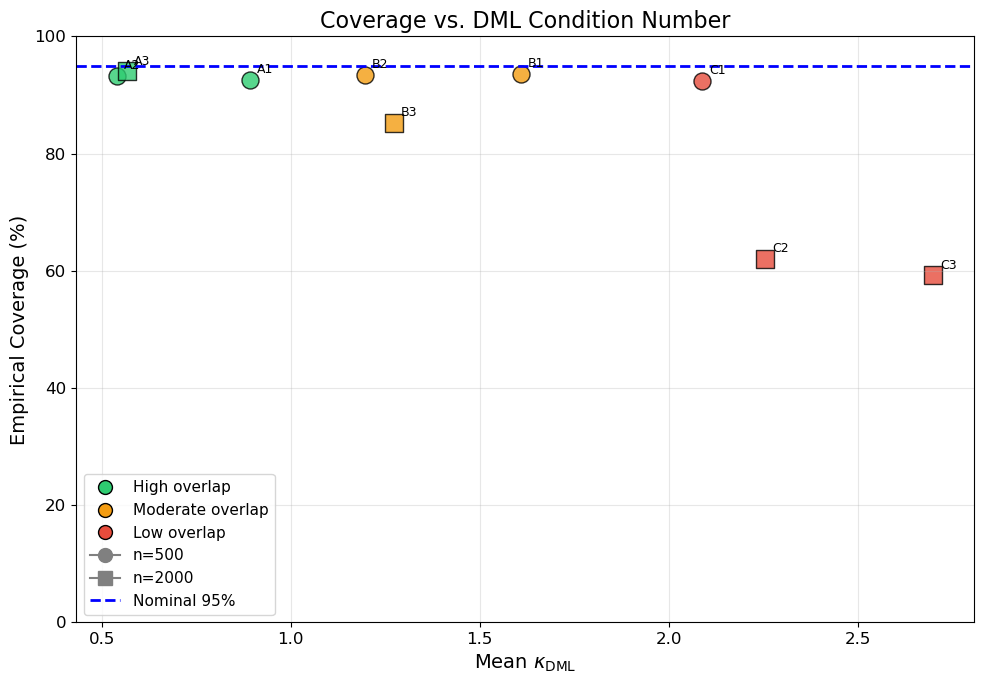

Saved to: ../results/coverage_vs_kappa.png


In [53]:
# Coverage vs kappa plot
fig, ax = plt.subplots(figsize=(10, 7))

# Color and marker settings
colors = {'high': '#2ecc71', 'moderate': '#f39c12', 'low': '#e74c3c'}
markers = {500: 'o', 2000: 's'}

for _, row in summary_df.iterrows():
    ax.scatter(
        row['mean_kappa'], row['coverage_pct'],
        c=colors[row['overlap']], marker=markers[row['n']],
        s=150, alpha=0.8, edgecolors='black', linewidths=1,
    )
    ax.annotate(
        row['dgp_id'], (row['mean_kappa'], row['coverage_pct']),
        textcoords='offset points', xytext=(5, 5), fontsize=9,
    )

# Nominal coverage
ax.axhline(y=95, color='blue', linestyle='--', linewidth=2, label='Nominal 95%')

ax.set_xlabel(r'Mean $\kappa_{\mathrm{DML}}$')
ax.set_ylabel('Empirical Coverage (%)')
ax.set_title('Coverage vs. DML Condition Number')
ax.set_ylim([0, 100])
ax.grid(True, alpha=0.3)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['high'],
           markersize=10, markeredgecolor='black', label='High overlap'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['moderate'],
           markersize=10, markeredgecolor='black', label='Moderate overlap'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['low'],
           markersize=10, markeredgecolor='black', label='Low overlap'),
    Line2D([0], [0], marker='o', color='gray', markersize=10, label='n=500'),
    Line2D([0], [0], marker='s', color='gray', markersize=10, label='n=2000'),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Nominal 95%'),
]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/coverage_vs_kappa.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{RESULTS_DIR}/coverage_vs_kappa.pdf', bbox_inches='tight')
plt.show()

print(f"Saved to: {RESULTS_DIR}/coverage_vs_kappa.png")

The plot shows a clear negative relationship between $\kappa_{\mathrm{DML}}$ and coverage. Well-conditioned designs (high overlap, $\kappa < 1.5$) achieve near-nominal 95% coverage, while severely ill-conditioned designs ($\kappa > 4$) show dramatic undercoverage.

### CI Length vs. $\kappa_{\mathrm{DML}}$

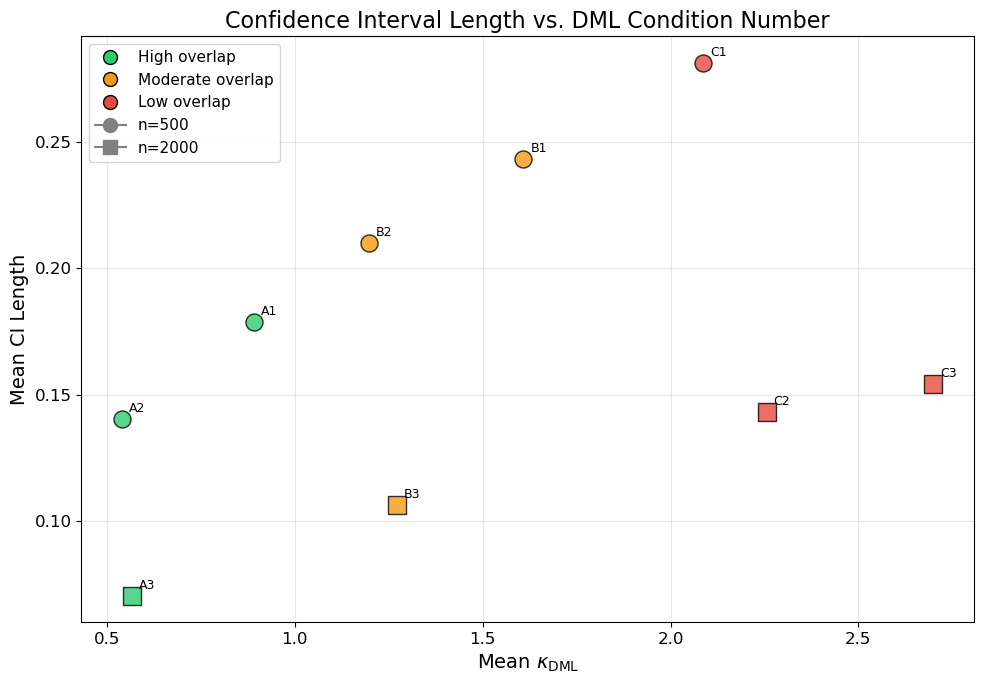

Saved to: ../results/ci_length_vs_kappa.png


In [54]:
# CI Length vs kappa
fig, ax = plt.subplots(figsize=(10, 7))

for _, row in summary_df.iterrows():
    ax.scatter(
        row['mean_kappa'], row['mean_ci_length'],
        c=colors[row['overlap']], marker=markers[row['n']],
        s=150, alpha=0.8, edgecolors='black', linewidths=1,
    )
    ax.annotate(
        row['dgp_id'], (row['mean_kappa'], row['mean_ci_length']),
        textcoords='offset points', xytext=(5, 5), fontsize=9,
    )

ax.set_xlabel(r'Mean $\kappa_{\mathrm{DML}}$')
ax.set_ylabel('Mean CI Length')
ax.set_title('Confidence Interval Length vs. DML Condition Number')
ax.grid(True, alpha=0.3)
ax.legend(handles=legend_elements[:5], loc='upper left')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ci_length_vs_kappa.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{RESULTS_DIR}/ci_length_vs_kappa.pdf', bbox_inches='tight')
plt.show()

print(f"Saved to: {RESULTS_DIR}/ci_length_vs_kappa.png")

CI length increases with $\kappa_{\mathrm{DML}}$. Notably, the benefit of larger $n$ (500 → 2000) is attenuated for ill-conditioned designs: compare A2 vs A3 (well-conditioned) with C1 vs C2 (ill-conditioned).

---
## 7. Summary and Interpretation

### Key Findings

In [55]:
# Correlation analysis
corr_cov = summary_df['mean_kappa'].corr(summary_df['coverage_pct'])
corr_rmse = summary_df['mean_kappa'].corr(summary_df['rmse'])

print("Correlation Analysis")
print("=" * 40)
print(f"Corr(κ_DML, Coverage):  {corr_cov:.3f}")
print(f"Corr(κ_DML, RMSE):      {corr_rmse:.3f}")

# Extreme cases
best = summary_df.loc[summary_df['coverage_pct'].idxmax()]
worst = summary_df.loc[summary_df['coverage_pct'].idxmin()]

print(f"\nBest coverage: DGP {best['dgp_id']} with κ={best['mean_kappa']:.2f}, "
      f"coverage={best['coverage_pct']:.1f}%")
print(f"Worst coverage: DGP {worst['dgp_id']} with κ={worst['mean_kappa']:.2f}, "
      f"coverage={worst['coverage_pct']:.1f}%")

Correlation Analysis
Corr(κ_DML, Coverage):  -0.771
Corr(κ_DML, RMSE):      0.884

Best coverage: DGP A3 with κ=0.57, coverage=94.0%
Worst coverage: DGP C3 with κ=2.70, coverage=59.2%


### Theoretical Interpretation

The simulation results are consistent with the paper's theoretical expansion:
$$
\hat{\theta} - \theta_0 = \kappa_{\mathrm{DML}} \cdot (S_n + B_n) + R_n
$$

As $\kappa_{\mathrm{DML}}$ grows:
1. **Variance amplification:** The score term $S_n = O_P(n^{-1/2})$ is multiplied by $\kappa_{\mathrm{DML}}$, inflating variance
2. **Bias amplification:** The nuisance bias $B_n$ is also multiplied by $\kappa_{\mathrm{DML}}$
3. **CI underperformance:** Standard errors scale with $\kappa_{\mathrm{DML}}$, but the actual error may grow faster due to bias amplification

### Practical Recommendations

1. **Always compute $\kappa_{\mathrm{DML}}$** as a diagnostic when reporting DML estimates
2. **Interpret with caution** when $\kappa_{\mathrm{DML}} > 3$: CIs may be unreliable
3. **Increasing $n$ helps but doesn't solve** the problem in severely ill-conditioned designs

---

## References

- Robinson, P.M. (1988). "Root-N-Consistent Semiparametric Regression." *Econometrica*, 56(4), 931–954.
- Chernozhukov, V. et al. (2018). "Double/Debiased Machine Learning for Treatment and Structural Parameters." *Econometrics Journal*, 21(1), C1–C68.
- Chernozhukov, V., Newey, W.K., & Singh, R. (2023). "A Simple and General Debiased Machine Learning Theorem with Finite-Sample Guarantees." *Biometrika*, 110(1), 257–264.
- Zimmert, M. (2018). "The Finite Sample Performance of Treatment Effect Estimators in High-Dimensional Settings." arXiv:1805.05067.
- Naghi, A. (2021). "Finite Sample Evaluation of Causal Machine Learning Methods." *Tinbergen Institute Discussion Paper* 21-090.
- Bach, P. et al. (2022). "DoubleML: An Object-Oriented Implementation of Double Machine Learning." *Journal of Statistical Software*, 108(3).

In [56]:
print("=" * 60)
print("SIMULATION STUDY COMPLETE")
print("=" * 60)
print(f"\nOutputs saved to: {os.path.abspath(RESULTS_DIR)}")
print("\nFiles:")
print("  - simulation_results_full.csv")
print("  - simulation_summary.csv")
print("  - coverage_vs_kappa.png/pdf")
print("  - ci_length_vs_kappa.png/pdf")

SIMULATION STUDY COMPLETE

Outputs saved to: /Users/gabrielsaco/Documents/GitHub/dml_paper/results

Files:
  - simulation_results_full.csv
  - simulation_summary.csv
  - coverage_vs_kappa.png/pdf
  - ci_length_vs_kappa.png/pdf
